In [1]:
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import t, pearsonr
import xgboost as xg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from scipy.stats import norm
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import XGBClassifier
import joblib
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
from scipy.stats import ttest_rel, ttest_1samp
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import optuna
import pandas as pd
import shap
import time
from sklearn.metrics import precision_score, recall_score
import pandas as pd
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_curve, roc_auc_score,
    accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from scipy.stats import ttest_1samp
import optuna
from sklearn.inspection import permutation_importance
import time
import os 


/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class XGBoostClassifierPipeline:
    def __init__(self, X, y, feature_sets, dataset_name, hyperparams=None, n_trials=10, n_folds=10, random_state=123, n_top=80):
        self.X = X
        self.y = y
        self.dataset_name = dataset_name  # Name of the dataset (e.g., "Lifelines" or "UK Biobank")
        self.n_top = n_top
        self.feature_sets = feature_sets
        self.hyperparams = hyperparams if hyperparams else {}
        self.models = {}
        self.best_params = {}
        self.n_trials = n_trials
        self.n_folds = n_folds
        self.roc_curves = {}
        self.pr_curves = {}
        self.random_state = random_state
        self.top_features = {}
        self.models_top_features = {}
        self.evaluation_metrics = {}  # Store evaluation metrics
        self.perm_importance_df = None  # Initialize permutation importance DataFrame

    def run_optimization(self, X, y):
        def objective(trial):
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
                'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
                'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'eval_metric': 'logloss'
            }
            cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
            cv_scores = cross_val_score(XGBClassifier(**param, random_state=self.random_state), X, y, cv=cv, scoring='f1_weighted')
            return cv_scores.mean()

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=2)
        return study.best_params

    def train_model_with_nested_cv(self):
        key = 'model'
        features = self.feature_sets[key]
        X_features = self.X[features]
    
        if key not in self.best_params:
            self.best_params[key] = self.hyperparams
    
        self.roc_curves = {}
        outer_cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Initialize storage for all fold results
        all_fold_metrics = {
            'accuracy': [], 'f1_weighted': [], 'roc_auc': [], 
            'sensitivity': [], 'specificity': [], 'precision': [], 'recall': []
        }
    
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_features, self.y)):
            X_train, X_test = X_features.iloc[train_idx], X_features.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
    
            model = XGBClassifier(**self.best_params[key], use_label_encoder=False, eval_metric='logloss', random_state=self.random_state)
            model.fit(X_train, y_train)
    
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
    
            # Store all fold metrics
            all_fold_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            all_fold_metrics['f1_weighted'].append(f1_score(y_test, y_pred, average='weighted'))
            all_fold_metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            
            all_fold_metrics['sensitivity'].append(sensitivity)
            all_fold_metrics['specificity'].append(specificity)
            all_fold_metrics['precision'].append(precision_score(y_test, y_pred))
            all_fold_metrics['recall'].append(recall_score(y_test, y_pred))
    
            # ROC curve data
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            self.roc_curves.setdefault(key, []).append({'fpr': fpr, 'tpr': tpr, 'auc': auc_score})
    
        # Calculate mean and SD for each metric
        self.evaluation_metrics[self.dataset_name] = {
            'Accuracy': f"{np.mean(all_fold_metrics['accuracy']):.2f} ± {np.std(all_fold_metrics['accuracy']):.2f}",
            'F1 Score': f"{np.mean(all_fold_metrics['f1_weighted']):.2f} ± {np.std(all_fold_metrics['f1_weighted']):.2f}",
            'ROC AUC': f"{np.mean(all_fold_metrics['roc_auc']):.2f} ± {np.std(all_fold_metrics['roc_auc']):.2f}",
            'Sensitivity': f"{np.mean(all_fold_metrics['sensitivity']):.2f} ± {np.std(all_fold_metrics['sensitivity']):.2f}",
            'Specificity': f"{np.mean(all_fold_metrics['specificity']):.2f} ± {np.std(all_fold_metrics['specificity']):.2f}",
            'Precision': f"{np.mean(all_fold_metrics['precision']):.2f} ± {np.std(all_fold_metrics['precision']):.2f}",
            'Recall': f"{np.mean(all_fold_metrics['recall']):.2f} ± {np.std(all_fold_metrics['recall']):.2f}",
            'Confusion Matrix': confusion_matrix(y_test, y_pred)  # Keep the last fold's CM
        }
        cm = confusion_matrix(y_test, y_pred)
        self.evaluation_metrics[self.dataset_name]['Confusion Matrix'] = cm

        final_model = XGBClassifier(**self.best_params[key], use_label_encoder=False, eval_metric='logloss', random_state=self.random_state)
        final_model.fit(X_features, self.y)
        self.models[key] = {'model': final_model, 'X': X_features, 'y': self.y}

    def calculate_permutation_importance(self, model_key, n_repeats=100):
        """
        Calculate permutation importance for the specified model.
        Returns mean importance, p-values, and standard deviations.
        """
        if model_key not in self.models:
            print(f"No model data found for key '{model_key}'.")
            return None
    
        model_data = self.models[model_key]
        model = model_data['model']
        X = model_data['X']
        y = model_data['y']
    
        # Calculate permutation importance
        result = permutation_importance(
            model, X, y, n_repeats=n_repeats, random_state=self.random_state, scoring='f1_weighted'
        )
    
        # Extract feature names and importance metrics
        feature_names = X.columns
        importances_mean = result.importances_mean
        importances_std = result.importances_std  # Standard deviation across repeats
        importances = result.importances  # All permutation results (n_features × n_repeats)
    
        # Initialize lists to store p-values and confidence intervals
        p_values = []
        conf_intervals = []
    
        # Calculate p-values and 95% confidence intervals for each feature
        for i in range(result.importances.shape[0]):
            imps = result.importances[i, :]
            
            # Calculate p-value
            if len(imps) > 1:
                p_value = ttest_1samp(imps, 0).pvalue
                # Calculate 95% confidence interval
                conf_int = np.percentile(imps, [2.5, 97.5])
            else:
                p_value = np.nan
                conf_int = [np.nan, np.nan]
                
            p_values.append(p_value)
            conf_intervals.append(conf_int)
    
        # Create a DataFrame to store all results
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances_mean,
            'Std': importances_std,  # Standard deviation
            'P-Value': p_values,
            'CI_lower': [ci[0] for ci in conf_intervals],
            'CI_upper': [ci[1] for ci in conf_intervals],
            'All_permutations': [imps for imps in importances]  # Store all permutation values
        })
    
        # Sort by importance
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
        # Filter features with p-value < 0.05 if desired
        self.perm_importance_df = importance_df[importance_df['P-Value'] < 0.05]
    
        return self.perm_importance_df

    

    def train_with_top_features(self):
        """
        Train a model using only the top features identified by permutation importance.
        """
        key = 'model'
        print("Training model with top features...")
    
        # Get top features from permutation importance
        if self.perm_importance_df is None:
            print("Permutation importance not calculated. Running permutation importance first...")
            self.calculate_permutation_importance(key)
    
        top_features = self.perm_importance_df['Feature'].tolist()
    
        if not top_features:
            print("No significant features found (p < 0.05). Using all features.")
            top_features = self.feature_sets[key]
    
        self.top_features[key] = top_features
        X_top = self.X[top_features]
    
        # Hyperparameter optimization for top features
        top_key = f"{key}_top_features"  # This generates 'model_top_features'
        print(f"Running hyperparameter optimization for {top_key}...")
        self.best_params[top_key] = self.run_optimization(X_top, self.y)
        print(f"Best parameters for {top_key}: {self.best_params[top_key]}")
    
        # Nested CV with top features
        outer_cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        self.roc_curves[top_key] = []
    
        # Initialize metrics storage
        top_outer_scores = {
            'accuracy': [], 'f1_weighted': [], 'roc_auc': [],
            'sensitivity': [], 'specificity': [], 
            'precision': [], 'recall': []
        }
    
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_top, self.y)):
            X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
    
            model = XGBClassifier(**self.best_params[top_key], use_label_encoder=False, objective="binary:logistic", 
                                eval_metric='logloss', random_state=self.random_state)
            model.fit(X_train, y_train)
    
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
    
            # Calculate all metrics
            top_outer_scores['accuracy'].append(accuracy_score(y_test, y_pred))
            top_outer_scores['f1_weighted'].append(f1_score(y_test, y_pred, average='weighted'))
            top_outer_scores['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
    
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
    
            top_outer_scores['sensitivity'].append(sensitivity)
            top_outer_scores['specificity'].append(specificity)
            top_outer_scores['precision'].append(precision)
            top_outer_scores['recall'].append(recall)
    
            # ROC curve data
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            self.roc_curves[top_key].append({'fpr': fpr, 'tpr': tpr, 'auc': auc_score})
    
        # Print metrics with standard deviations
        print("\nTop Features Model Evaluation Metrics:")
        print(f"Average Accuracy: {np.mean(top_outer_scores['accuracy']):.3f} ± {np.std(top_outer_scores['accuracy']):.3f}")
        print(f"Average F1 Score: {np.mean(top_outer_scores['f1_weighted']):.3f} ± {np.std(top_outer_scores['f1_weighted']):.3f}")
        print(f"Average ROC AUC: {np.mean(top_outer_scores['roc_auc']):.3f} ± {np.std(top_outer_scores['roc_auc']):.3f}")
        print(f"Average Sensitivity: {np.mean(top_outer_scores['sensitivity']):.3f} ± {np.std(top_outer_scores['sensitivity']):.3f}")
        print(f"Average Specificity: {np.mean(top_outer_scores['specificity']):.3f} ± {np.std(top_outer_scores['specificity']):.3f}")
        print(f"Average Precision: {np.mean(top_outer_scores['precision']):.3f} ± {np.std(top_outer_scores['precision']):.3f}")
        print(f"Average Recall: {np.mean(top_outer_scores['recall']):.3f} ± {np.std(top_outer_scores['recall']):.3f}")
    
            # Store metrics with mean ± SD format
        self.evaluation_metrics[f"{self.dataset_name}_top"] = {
            'Accuracy': f"{np.mean(top_outer_scores['accuracy']):.2f} ± {np.std(top_outer_scores['accuracy']):.2f}",
            'F1 Score': f"{np.mean(top_outer_scores['f1_weighted']):.2f} ± {np.std(top_outer_scores['f1_weighted']):.2f}",
            'ROC AUC': f"{np.mean(top_outer_scores['roc_auc']):.2f} ± {np.std(top_outer_scores['roc_auc']):.2f}",
            'Sensitivity': f"{np.mean(top_outer_scores['sensitivity']):.2f} ± {np.std(top_outer_scores['sensitivity']):.2f}",
            'Specificity': f"{np.mean(top_outer_scores['specificity']):.2f} ± {np.std(top_outer_scores['specificity']):.2f}",
            'Precision': f"{np.mean(top_outer_scores['precision']):.2f} ± {np.std(top_outer_scores['precision']):.2f}",
            'Recall': f"{np.mean(top_outer_scores['recall']):.2f} ± {np.std(top_outer_scores['recall']):.2f}",
            'Confusion Matrix': confusion_matrix(y_test, y_pred)  # Keep the last fold's CM
        }
    
        # Final model with top features
        final_model = XGBClassifier(**self.best_params[top_key], 
                                  eval_metric='logloss', random_state=self.random_state)
        final_model.fit(X_top, self.y)
        self.models_top_features[top_key] = {'model': final_model, 'X': X_top, 'y': self.y}
        print(f"Model stored under key: {top_key}")

    def get_top_shap_features(self, model_key, n=None):
        """
        Calculates SHAP values for a model and returns the names of the top N features.
        """
        if n is None:
            n = self.n_top  # Use the instance variable
        
        if model_key not in self.models:
            print(f"No model data found for key '{model_key}'.")
            return None
    
        model_data = self.models[model_key]
        model = model_data['model']
        X = model_data['X']
    
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)
        mean_shap_values = np.abs(shap_values.values).mean(axis=0)
    
        # Get indices of top N features using instance variable
        top_indices = np.argsort(mean_shap_values)[::-1][:n]
        top_features = X.columns[top_indices].tolist()
    
        return top_features
    def calculate_shap_values(self, model_key='model_top_features'):
        """
        Calculate SHAP values for the specified model and return the sorted feature names, their importance, and colors.
        """
        # Define special features based on the dataset
        if self.dataset_name == "Lifelines":
            special_features = {  'Antidepressant use',
                'Childhood trauma score',  'Depressive symptoms score', 'Anxiety symptoms score'
                
            }
        else:  # UK Biobank
            special_features = {  'Antidepressant use',
                'Childhood trauma score',  'Depressive symptoms score', 'Anxiety symptoms score'
                 
            }
    
        special_color = '#FF5733'
        default_color = '#3498DB'
        max_features = self.n_top
    
        if model_key in self.models_top_features:
            model_data = self.models_top_features[model_key]
            model = model_data['model']
            X_test = model_data['X']
    
            explainer = shap.Explainer(model, X_test)
            shap_values = explainer(X_test)
    
            mean_shap_values = np.abs(shap_values.values).mean(axis=0)
            feature_names = X_test.columns
            feature_importance = np.abs(mean_shap_values)
    
            idx = np.argsort(feature_importance)[::-1][:max_features]
            sorted_names = [feature_names[i] for i in idx]
            sorted_importance = feature_importance[idx]
    
            colors = [special_color if name in special_features else default_color for name in sorted_names]
    
            return sorted_names, sorted_importance, colors
        else:
            print(f"No model data found for key '{model_key}'.")
            return None, None, None
    def finalize_plots(self, other_pipeline=None):
        plt.figure(figsize=(8, 6))
        plt.rcParams['font.size'] = 12

        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

        # Plot ROC for current dataset
        top_features_key = next((key for key in self.roc_curves.keys() if '_top' in key), None)
        if top_features_key:
            roc_data = self.roc_curves[top_features_key]
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)

            for fold_data in roc_data:
                fpr = fold_data['fpr']
                tpr = fold_data['tpr']
                auc = fold_data['auc']
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                aucs.append(auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)

            plt.plot(mean_fpr, mean_tpr, label=f"AUC {self.dataset_name} = {mean_auc:.2f} ± {std_auc:.2f}", lw=2, alpha=0.8)

        # Plot ROC for other dataset if provided
        if other_pipeline:
            other_roc_data = other_pipeline.roc_curves.get(top_features_key, [])
            if other_roc_data:
                tprs_other = []
                aucs_other = []
                mean_fpr_other = np.linspace(0, 1, 100)

                for fold_data in other_roc_data:
                    fpr = fold_data['fpr']
                    tpr = fold_data['tpr']
                    auc = fold_data['auc']
                    tprs_other.append(np.interp(mean_fpr_other, fpr, tpr))
                    tprs_other[-1][0] = 0.0
                    aucs_other.append(auc)

                mean_tpr_other = np.mean(tprs_other, axis=0)
                mean_tpr_other[-1] = 1.0
                mean_auc_other = np.mean(aucs_other)
                std_auc_other = np.std(aucs_other)

                plt.plot(mean_fpr_other, mean_tpr_other, label=f"AUC {other_pipeline.dataset_name} = {mean_auc_other:.2f} ± {std_auc_other:.2f}", lw=2, alpha=0.8)

        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        #plt.title('ROC Curve', fontsize=16)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores/roc_curve.png', dpi=600)
        plt.show()


    def calculate_and_plot_pr_curve(self, model_key, other_pipeline=None):
        # Validate model exists
        if model_key not in self.models_top_features:
            print(f"No model data for key '{model_key}' in {self.dataset_name}.")
            return
    
        # Extract model and test data
        model_data = self.models_top_features[model_key]
        model = model_data['model']
        X_test = model_data['X']
        y_test = model_data['y']
    
        # Calculate PR metrics
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
    
        # Always save to self.pr_curves
        self.pr_curves[model_key] = {
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds,
            'average_precision': avg_precision
        }
    
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, 
                 label=f'{self.dataset_name} (AP={avg_precision:.2f})', 
                 lw=2)
    
        # Add other pipeline data if provided
        if other_pipeline:
            other_data = other_pipeline.pr_curves.get(model_key)
            if other_data:
                plt.plot(other_data['recall'], other_data['precision'],
                         label=f'{other_pipeline.dataset_name} (AP={other_data["average_precision"]:.2f})',
                         lw=2, linestyle='--')
            else:
                print(f"No PR data for '{model_key}' in {other_pipeline.dataset_name}.")
    
        plt.xlabel('Recall')
        plt.ylabel('Precision')
       # plt.title('PR Curve Comparison')
        plt.legend()
        plt.grid(True)
        plt.savefig('/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores/pr_curve.png', dpi=600)
        plt.show()




    def get_evaluation_metrics_table(self, other_pipeline=None):
        """
        Get evaluation metrics as a DataFrame with mean ± SD format.
        """
        # Get metrics from current pipeline
        metrics_df = pd.DataFrame(self.evaluation_metrics[self.dataset_name], index=[self.dataset_name])
        metrics_df = metrics_df.drop('Confusion Matrix', axis=1)  # Exclude CM
        
        # Get metrics from other pipeline if provided
        if other_pipeline:
            other_metrics = pd.DataFrame(
                other_pipeline.evaluation_metrics[other_pipeline.dataset_name],
                index=[other_pipeline.dataset_name]
            )
            other_metrics = other_metrics.drop('Confusion Matrix', axis=1)
            metrics_df = pd.concat([metrics_df, other_metrics])
        
        # Save to CSV
        metrics_df.to_csv('/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores/evaluation_metrics.csv')
            # Round all numerical values to 2 decimal places
        return metrics_df.round(2)

    def plot_confusion_matrix_heatmap(self, model_key='model'):
        """
        Plot a heatmap of the confusion matrix for the specified model with improved labels and styling.
        """
        if model_key not in self.models:
            print(f"No model data found for key '{model_key}'.")
            return
    
        # Get the confusion matrix from evaluation metrics
        cm = self.evaluation_metrics[self.dataset_name]['Confusion Matrix']
    
        # Create a heatmap with improved styling
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d',  # Display integers
            cmap='YlOrRd',  # Use a yellow-orange-red color palette
            annot_kws={'size': 14},  # Increase annotation font size
            xticklabels=['Predicted CVD Absent', 'Predicted CVD Present'],
            yticklabels=['Actual CVD Absent', 'Actual CVD Present'], 
            linewidths=0.5,  # Add lines between cells
            linecolor='gray'  # Line color
        )
               # plt.title(f'{self.dataset_name}', fontsize=16, pad=20)
        plt.xlabel('Predicted Outcome', fontsize=14)  # More professional x-axis title
        plt.ylabel('Actual Outcome', fontsize=14)  # More professional y-axis title
        plt.xticks(fontsize=12)  # Increase x-axis label font size
        plt.yticks(fontsize=12)  # Increase y-axis label font size
        plt.tight_layout()
        # Define the base directory and ensure it exists
        output_dir = "/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores"
        os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
        
        # Save the figure with dynamic filename
        plt.savefig(
            f"{output_dir}/{self.dataset_name}_confusion_matrix.png", 
            dpi=600,
            bbox_inches='tight'  # Optional: prevents cropping
        )
        
        plt.show()


    

In [8]:
df1 = pd.read_csv('balanced_data_lifelines.csv')

df2 = pd.read_csv('balanced_data_UKB.csv')
# # Define feature sets
feature_sets_lifelines = [
   'Cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'Triglycerides',
       'Glucose', 'Glycated haemoglobin', 
    'Systolic blood pressure','Diastolic blood pressure', 'Hypertension', 
    
    'Age', 'CVD Family history',
        'Gender', 'Diabetes',  'Smoking status', 
       'Physical activity', 
  
  'Antidepressant use',  'Childhood trauma score', 'Depressive symptoms score', 'Anxiety symptoms score',

      
]


# Initialize pipelines
pipeline_lifelines = XGBoostClassifierPipeline(
    X=df1[feature_sets_lifelines], y=df1['CVD'], feature_sets={'model': feature_sets_lifelines}, dataset_name="Lifelines"
)


df2.columns

feature_sets_ukb = [
  'Cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'Triglycerides',
       'Glucose', 'Glycated haemoglobin', 
    'Systolic blood pressure','Diastolic blood pressure', 'Hypertension', 
    'Age', 'CVD Family history',
  'Gender', 'Diabetes',     'Smoking status',
    'Physical activity', 
    
    'Childhood trauma score',
     
    'Antidepressant use',   'Depressive symptoms score', 'Anxiety symptoms score',
       
       
]

pipeline_ukb = XGBoostClassifierPipeline(
    X=df2[feature_sets_ukb], y=df2['CVD'], feature_sets={'model': feature_sets_ukb}, dataset_name="UK Biobank"
)




In [9]:
# Train models
pipeline_lifelines.train_model_with_nested_cv()

/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:49:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:50:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:50:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encod

In [10]:
pipeline_ukb.train_model_with_nested_cv()

/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:55:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:00:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encod

In [11]:
permutations_results_lifelines = pipeline_lifelines.calculate_permutation_importance('model')

In [12]:
permutations_results_ukb = pipeline_ukb.calculate_permutation_importance('model')

In [13]:
pipeline_lifelines.train_with_top_features()

[I 2025-05-14 19:31:43,144] A new study created in memory with name: no-name-77f775ae-86fe-4f3f-9bb1-662bc300fd73


Training model with top features...
Running hyperparameter optimization for model_top_features...


[I 2025-05-14 19:39:44,282] Trial 0 finished with value: 0.8409603148600036 and parameters: {'n_estimators': 415, 'max_depth': 3, 'learning_rate': 0.0019665376251377822, 'subsample': 0.7495260202553833, 'colsample_bytree': 0.7417908878390319, 'min_child_weight': 2, 'alpha': 2.3411249775593512e-05, 'lambda': 1.5294456352198855, 'gamma': 0.0006580549395397165}. Best is trial 0 with value: 0.8409603148600036.
[I 2025-05-14 19:43:53,377] Trial 1 finished with value: 0.8433665072757209 and parameters: {'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.009965451840236776, 'subsample': 0.6134736043698815, 'colsample_bytree': 0.91041311782987, 'min_child_weight': 4, 'alpha': 0.04426461713481277, 'lambda': 1.6115069147718295e-07, 'gamma': 1.1263847676405825e-08}. Best is trial 1 with value: 0.8433665072757209.


Best parameters for model_top_features: {'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.009965451840236776, 'subsample': 0.6134736043698815, 'colsample_bytree': 0.91041311782987, 'min_child_weight': 4, 'alpha': 0.04426461713481277, 'lambda': 1.6115069147718295e-07, 'gamma': 1.1263847676405825e-08}


/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:43:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:44:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:44:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encod


Top Features Model Evaluation Metrics:
Average Accuracy: 0.843 ± 0.011
Average F1 Score: 0.843 ± 0.011
Average ROC AUC: 0.915 ± 0.010
Average Sensitivity: 0.844 ± 0.012
Average Specificity: 0.843 ± 0.023
Average Precision: 0.843 ± 0.018
Average Recall: 0.844 ± 0.012
Model stored under key: model_top_features


In [14]:
pipeline_ukb.train_with_top_features()

[I 2025-05-14 19:48:10,096] A new study created in memory with name: no-name-feebd4a2-81f9-419a-b8f3-cd575fa971e1


Training model with top features...
Running hyperparameter optimization for model_top_features...


[I 2025-05-14 20:07:07,776] Trial 0 finished with value: 0.7255095771003844 and parameters: {'n_estimators': 380, 'max_depth': 6, 'learning_rate': 0.0019224626517661604, 'subsample': 0.6667294265027083, 'colsample_bytree': 0.7961863994541066, 'min_child_weight': 5, 'alpha': 1.0115781235053654e-08, 'lambda': 0.23447100670659687, 'gamma': 0.0008067494795717357}. Best is trial 0 with value: 0.7255095771003844.
[I 2025-05-14 20:14:15,381] Trial 1 finished with value: 0.7329100919382255 and parameters: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.023304802404039277, 'subsample': 0.8753911050970911, 'colsample_bytree': 0.6088664873290716, 'min_child_weight': 4, 'alpha': 0.6701945509143752, 'lambda': 5.744362200050491, 'gamma': 0.07205559619544966}. Best is trial 1 with value: 0.7329100919382255.


Best parameters for model_top_features: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.023304802404039277, 'subsample': 0.8753911050970911, 'colsample_bytree': 0.6088664873290716, 'min_child_weight': 4, 'alpha': 0.6701945509143752, 'lambda': 5.744362200050491, 'gamma': 0.07205559619544966}


/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:14:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:15:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/groups/umcg-lifelines/tmp02/projects/ov20_0110/tensorflow_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:16:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encod


Top Features Model Evaluation Metrics:
Average Accuracy: 0.733 ± 0.014
Average F1 Score: 0.733 ± 0.014
Average ROC AUC: 0.825 ± 0.014
Average Sensitivity: 0.696 ± 0.020
Average Specificity: 0.770 ± 0.010
Average Precision: 0.752 ± 0.012
Average Recall: 0.696 ± 0.020
Model stored under key: model_top_features


dict_keys(['model_top_features'])


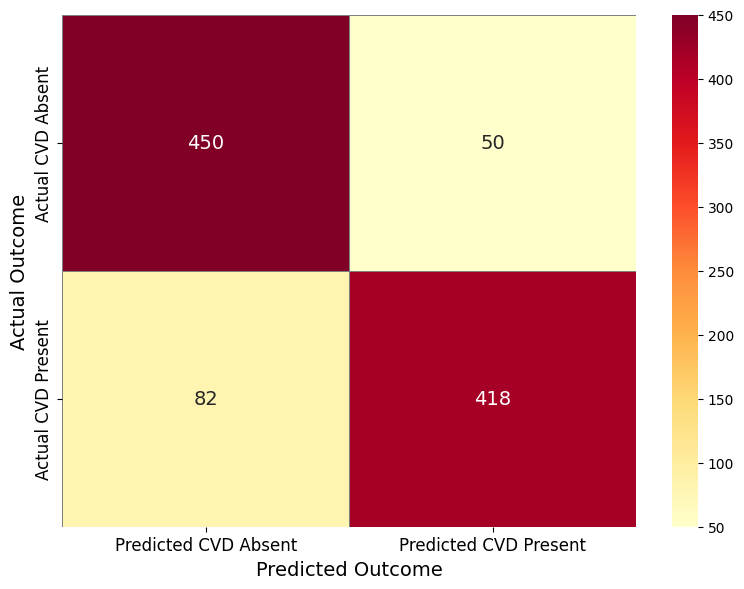

In [15]:

print(pipeline_lifelines.models_top_features.keys())
pipeline_lifelines.plot_confusion_matrix_heatmap()


dict_keys(['model_top_features'])


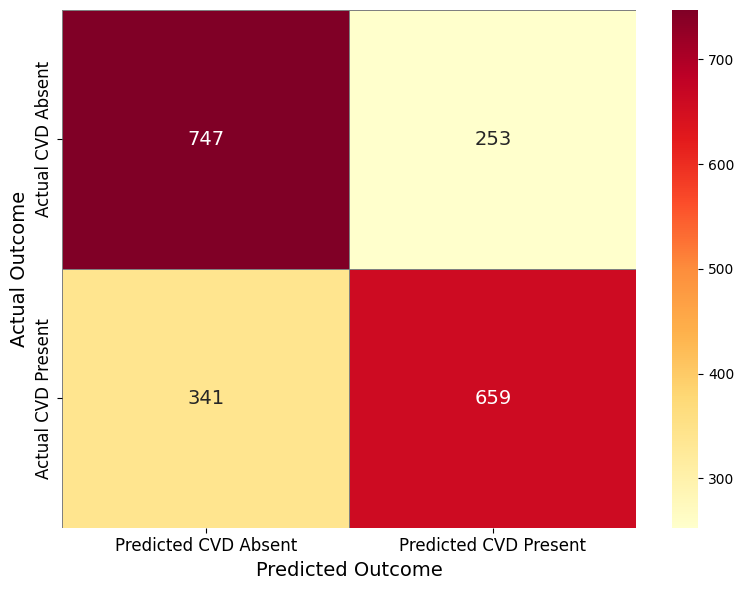

In [16]:
print(pipeline_ukb.models_top_features.keys())
pipeline_ukb.plot_confusion_matrix_heatmap()

In [17]:
print(pipeline_lifelines.models_top_features.keys())
print(pipeline_ukb.models_top_features.keys())

dict_keys(['model_top_features'])
dict_keys(['model_top_features'])


In [18]:
# plot_combined_shap_values(pipeline_lifelines, pipeline_ukb)
print(pipeline_lifelines.pr_curves.keys())

dict_keys([])


In [19]:

print(pipeline_ukb.pr_curves.keys())

dict_keys([])


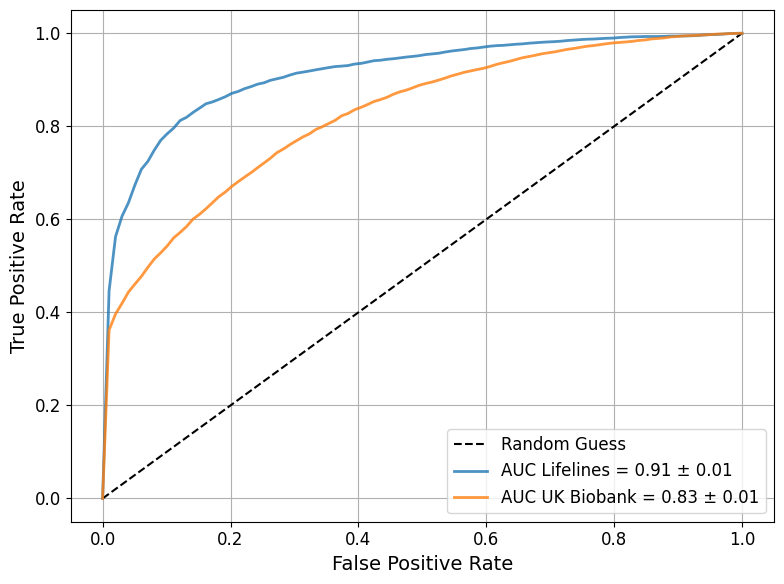

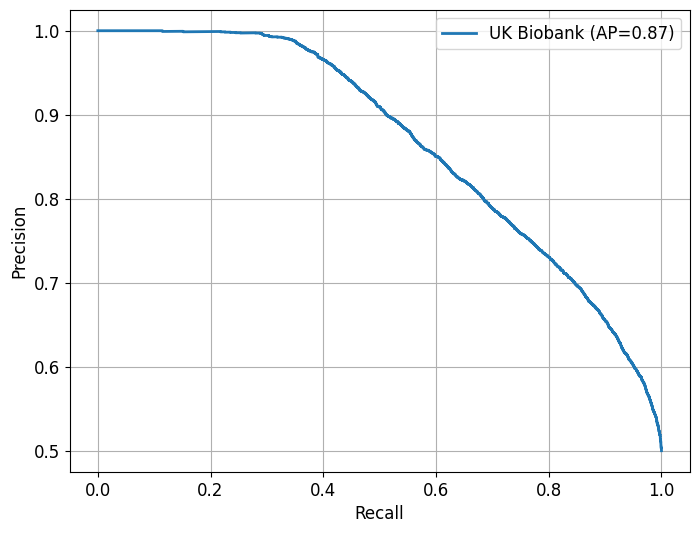

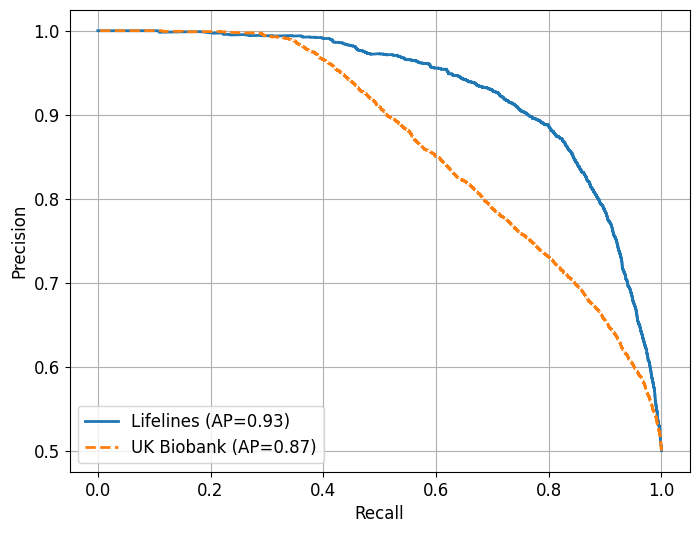

In [20]:
# Generate combined plots
pipeline_lifelines.finalize_plots(other_pipeline=pipeline_ukb)

pipeline_ukb.calculate_and_plot_pr_curve('model_top_features')

# Step 2: Plot PR curves for Lifelines and UK Biobank
pipeline_lifelines.calculate_and_plot_pr_curve('model_top_features', other_pipeline=pipeline_ukb)



In [21]:
# # Get evaluation metrics table
# metrics_table = pipeline_lifelines.get_evaluation_metrics_table(other_pipeline=pipeline_ukb)
# metrics_table

In [15]:

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.patches import Patch

# def plot_feature_importance_side_by_side(perm_importance_lifelines, perm_importance_ukb):
#     plt.rcParams['font.size'] = 18
#     """
#     Plot feature importance for Lifelines and UK Biobank side by side.
#     """
#     # Define the set of features to highlight
#     highlight_features = {
#           'Antidepressant use',  'Childhood trauma score', 'Depressive symptoms score', 'Anxiety symptoms score'
#     }
    

#     # Set up the figure and subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 14))
#     sns.set_style("whitegrid")

#     # Plot Lifelines feature importance
#     plot_single_feature_importance(perm_importance_lifelines, highlight_features, ax1, "Lifelines")

#     # Plot UK Biobank feature importance
#     plot_single_feature_importance(perm_importance_ukb, highlight_features, ax2, "UK Biobank")

#     # Add a common legend
#     legend_elements = [
#         Patch(facecolor='#FF5733', edgecolor='#FF5733', label='Mental Health Data'),
#         Patch(facecolor='#3498DB', edgecolor='#3498DB', label='Demographic, Clinical and Lifestyle factors')
#     ]
#     fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), fontsize=18, ncol=2)

#     plt.tight_layout()
#     #plt.savefig('/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores/feature_importance_plot.png', dpi=600, bbox_inches='tight')
#     plt.show()

# def plot_single_feature_importance(importance_df, highlight_features, ax, title):
#     """
#     Helper function to plot feature importance with proper error bars.
#     """
#     plt.rcParams['font.size'] = 18
    
#     # Extract values and sort by importance
#     df_sorted = importance_df.sort_values('Importance', ascending=True)
#     features = df_sorted['Feature'].values
#     importance = df_sorted['Importance'].values
#     std_dev = df_sorted['Std'].values
#     p_values = df_sorted['P-Value'].values
#     ci_lower = df_sorted['CI_lower'].values
#     ci_upper = df_sorted['CI_upper'].values

#     # Create color palette
#     colors = ['#FF5733' if feature in highlight_features else '#3498DB' for feature in features]

#     # Create positions for bars
#     y_pos = np.arange(len(features))
    
#     # Plot bars with error bars representing 95% CI
#     bars = ax.barh(y_pos, importance, xerr=[importance - ci_lower, ci_upper - importance],
#                   color=colors, alpha=0.8, error_kw=dict(lw=2, capsize=5, capthick=2))

#     # Annotations for significant features
#     for i, (feature, imp, p, ci_l, ci_u) in enumerate(zip(features, importance, p_values, ci_lower, ci_upper)):
#         if p < 0.05:  # Only annotate significant features
#             p_text = "p < .001" if p < 0.001 else f"p = {p:.3f}"
#             # Position text at the end of the error bar
#             ax.text(ci_u + 0.01, i, f"{imp:.3f} ({p_text})", va='center', fontsize=16)

#     # Customize the plot
#     ax.set_xlabel("Permutation Importance", fontsize=18)
#     ax.set_ylabel("Features", fontsize=18)
#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(features, fontsize=18)
#     ax.set_title(title, fontsize=18)
#     ax.set_xlim(left=0)  # Start x-axis at 0 for better readability

# # Example usage
# plot_feature_importance_side_by_side(permutations_results_lifelines, permutations_results_ukb)
df1.columns

Index(['Diastolic blood pressure', 'Systolic blood pressure', 'Age',
       'Cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'Triglycerides',
       'Glucose', 'Glycated haemoglobin', 'Childhood trauma score',
       'Depressive symptoms score', 'Anxiety symptoms score',
       'Physically abused by family as a child',
       'Felt hated by family member as a child',
       'Sexually molested as a child',
       'Someone to take to doctor when needed as a child', 'Felt loved',
       'Hypertension', 'Smoking status', 'Physical activity', 'Depressed mood',
       'Anhedonia', 'Appetite changes', 'Sleep problems',
       'Psychomotor changes', 'Fatigue', 'Feelings of inadequacy',
       'Cognitive problems', 'Suicidal ideation', 'Anxiety', 'Restlessness',
       'Lack of relaxation', 'Concentration problems', 'Irritability',
       'Antidepressant use', 'Diabetes', 'Gender', 'CVD Family history',
       'CVD'],
      dtype='object')

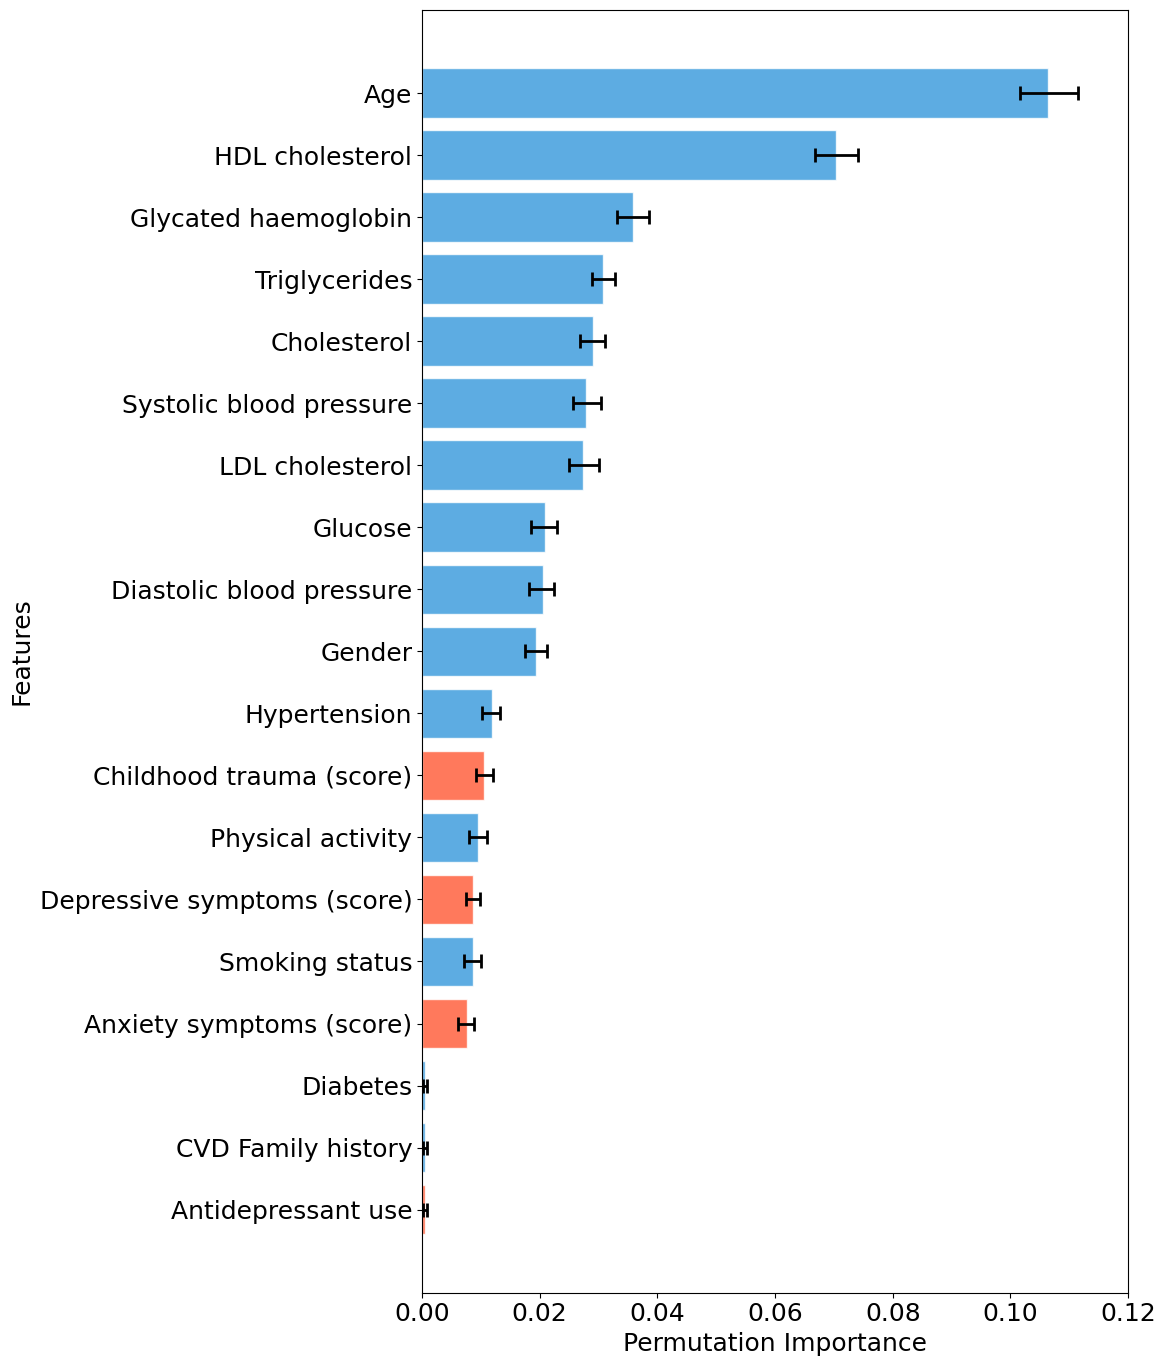

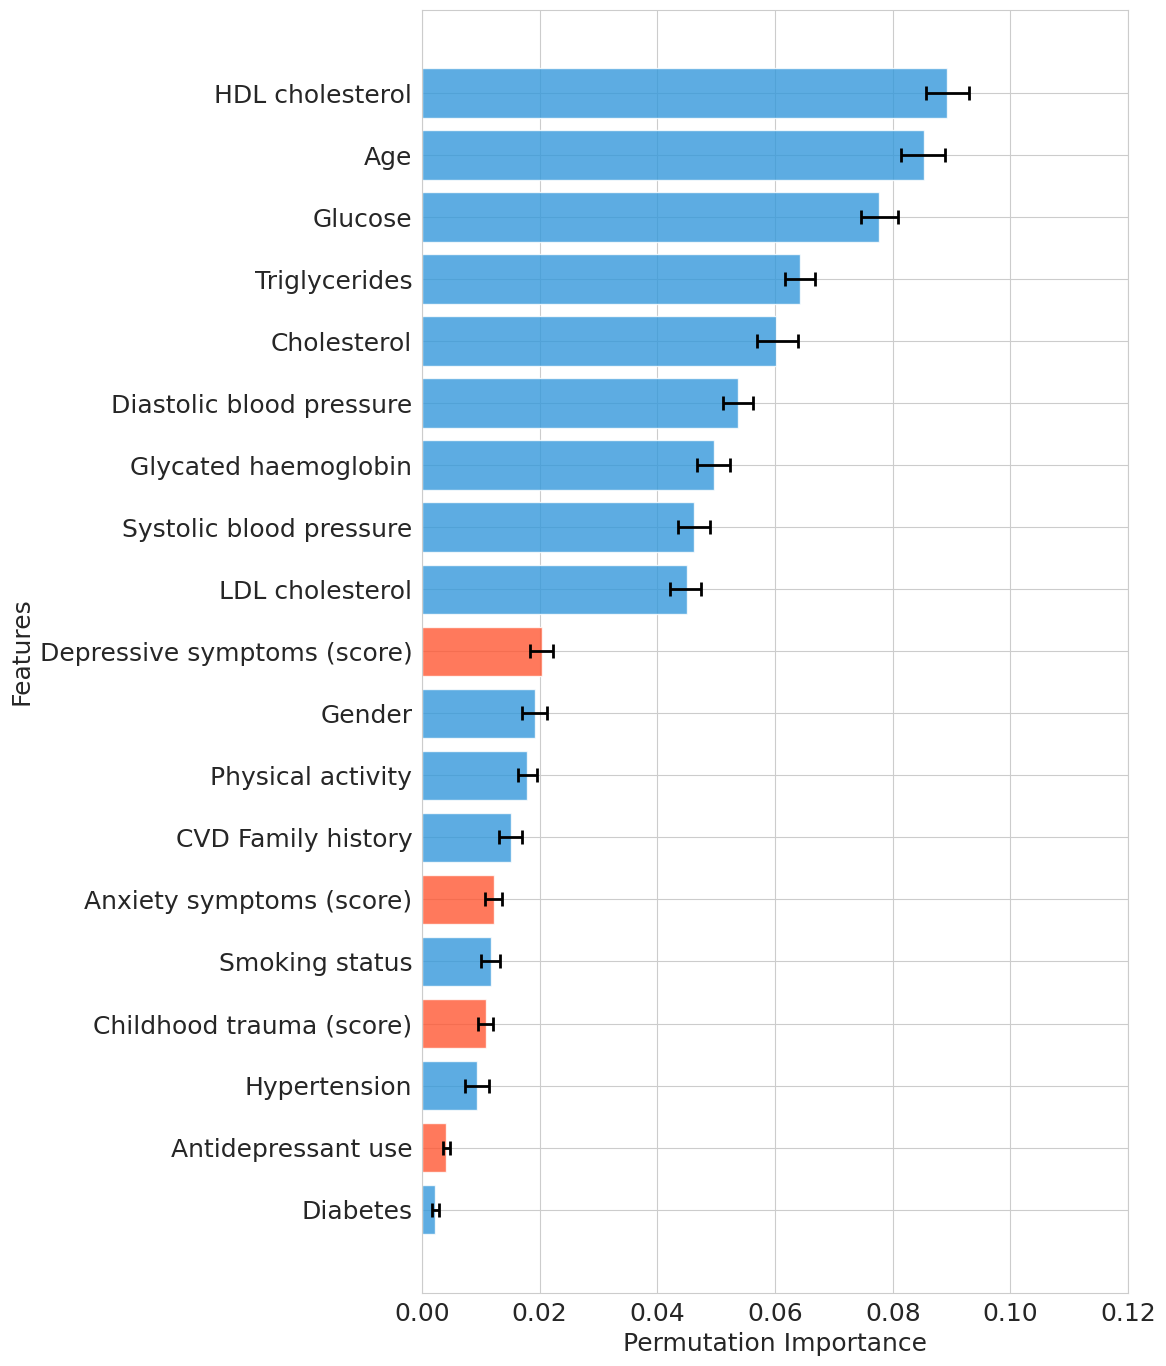

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from IPython.display import display

# Define output directory
output_dir = "/groups/umcg-lifelines/tmp02/projects/ov20_0110/merge analysis/results scores"

def plot_feature_importance_separately(perm_importance_lifelines, perm_importance_ukb):
    plt.rcParams['font.size'] = 18
    
    # Define the original and renamed feature names
    feature_rename_map = {
        'Childhood trauma score': 'Childhood trauma (score)',
        'Depressive symptoms score': 'Depressive symptoms (score)',
        'Anxiety symptoms score': 'Anxiety symptoms (score)'
    }
    
    # Highlight features using the NEW names
    highlight_features = {
        'Antidepressant use', 
        'Childhood trauma (score)',
        'Depressive symptoms (score)',
        'Anxiety symptoms (score)'
    }
    
    # Process and plot Lifelines data
    fig1 = plot_single_feature_importance_figure(
        perm_importance_lifelines, 
        feature_rename_map,
        highlight_features, 
        "",
        os.path.join(output_dir, 'feature_importance_lifelinesScore.png')
    )
    
    # Process and plot UK Biobank data
    fig2 = plot_single_feature_importance_figure(
        perm_importance_ukb, 
        feature_rename_map,
        highlight_features, 
        "",
        os.path.join(output_dir, 'feature_importance_ukbScore.png')
    )
    
    # Display both in notebook
    display(fig1)
    display(fig2)
    
    # Close figures to free memory
    plt.close(fig1)
    plt.close(fig2)

def plot_single_feature_importance_figure(importance_df, rename_map, highlight_features, title, filename):
    fig, ax = plt.subplots(figsize=(12, 14))
    sns.set_style("whitegrid")
    
    # Create a copy and rename features
    df = importance_df.copy()
    df['Feature'] = df['Feature'].replace(rename_map)
    
    # Fix column name (handles both "Importance" and "Importance")
    importance_col = 'Importance' if 'Importance' in df.columns else 'Importance'
    
    # Sort using the renamed features
    df_sorted = df.sort_values(importance_col, ascending=True)
    features = df_sorted['Feature'].values
    importance = df_sorted[importance_col].values
    ci_lower = df_sorted['CI_lower'].values
    ci_upper = df_sorted['CI_upper'].values

    # Apply highlighting - use the NEW feature names
    colors = ['#FF5733' if feature in highlight_features else '#3498DB' for feature in features]
    y_pos = np.arange(len(features))
    
    # Plot with error bars
    ax.barh(y_pos, importance, xerr=[importance - ci_lower, ci_upper - importance],
           color=colors, alpha=0.8, error_kw=dict(lw=2, capsize=5, capthick=2))
    
    # Customize plot with fixed x-axis range
    ax.set_xlabel("Permutation Importance", fontsize=18)
    ax.set_ylabel("Features", fontsize=18)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=18)
    ax.set_title(title, fontsize=18, pad=20)
    ax.set_xlim(0, 0.12)  # Fixed x-axis range from 0.0 to 0.15
    
    plt.tight_layout()
    
    # Save to HPC
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    
    return fig

plot_feature_importance_separately(permutations_results_lifelines, permutations_results_ukb)